In [6]:
from gmorph import reduce, combine, fit, save, tipps

# Be careful doing this, it is kind of necessary for a clean output because astropy throws a bunch of warnings even when things
# are working fine, BUT it is often the only thing it does. This means that often when it does go wrong there is no error when
# running the code, only warnings. Only do this when you know the code is likely to work.
import warnings
warnings.filterwarnings('ignore')

import numpy as np

In [7]:
dirnam = "C:/Users/Levente Kardkovács/Documents/Astroweek24"
darks = "Dark_110124"
objnam = "M106"

Master bias created in: 0 s.


INFO:astropy:splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]
Master dark created in: 37.3507 s.


INFO:astropy:splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]
Master flat created in: 80.7868 s.
Reduced science frames created in: 58.0869 s.
Background subtraction in: 201.248 s.


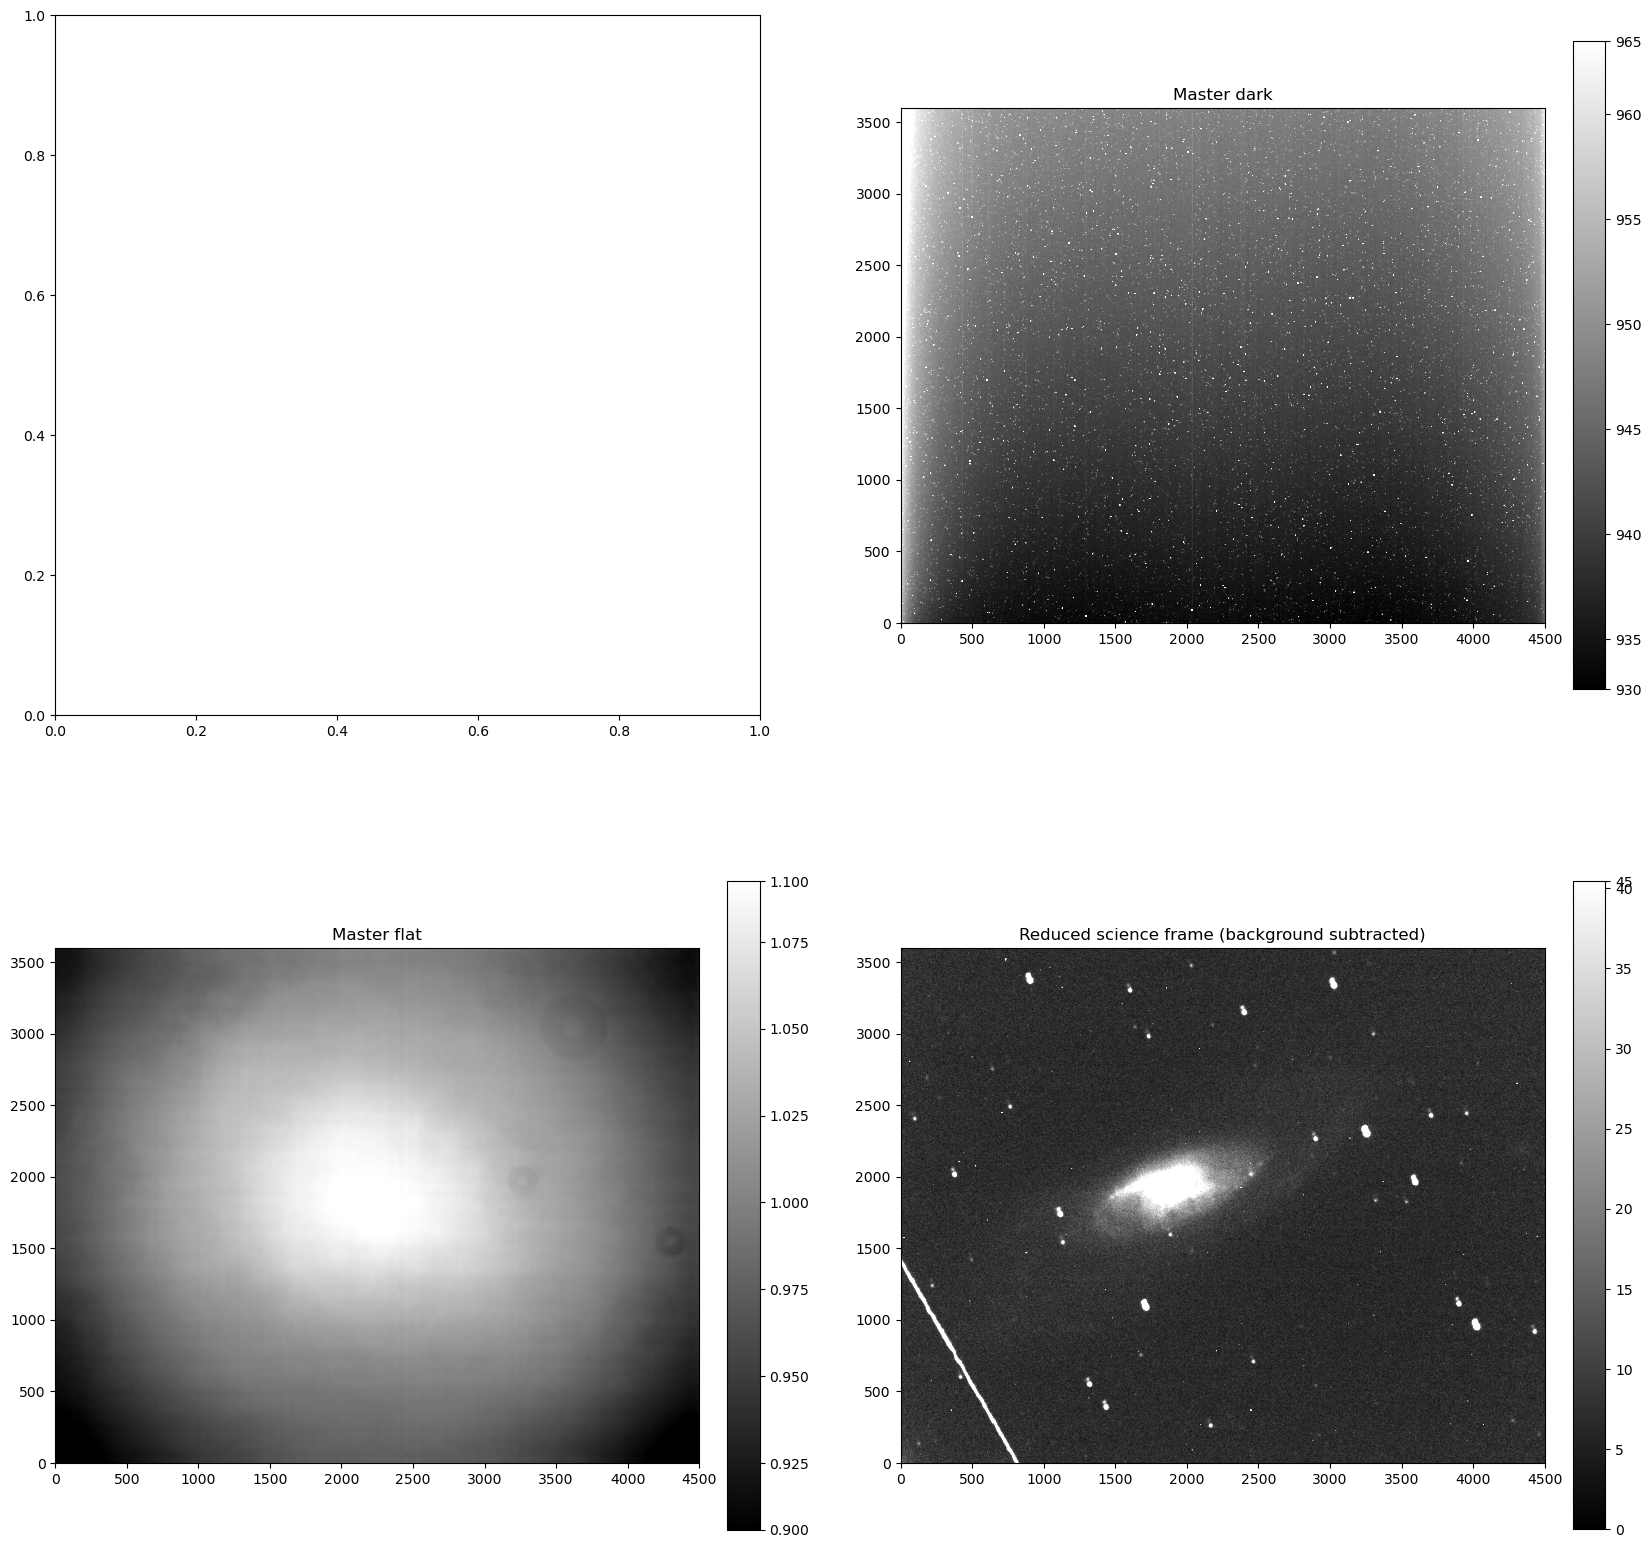

In [3]:
# Subtract bias, dark and flat frames as desired. Also subtract the sky background.
# Bias not yet implemented

sc_bgsub, redparam = reduce(dirnam, darks, objnam, show=True, size=np.array([4500, 3600]), flat=True, export=True,
                            dark_args = {'scl':5, 'sch':5, 'expt':30.0},
                            flat_args = {'scl':5, 'sch':5, 'expt':0.5},
                            sci_args = {'scl':5, 'sch':5, 'expt':30.0})

In [4]:
import time
import os

from convenience_functions import show_image

import matplotlib.pyplot as plt
import numpy as np

import ccdproc as ccdp

from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy import units as u

from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

import astroalign as aa

In [9]:
def combine(images, method="median", dsig=5e5, show=False, export=True):
    """
    Aligns astronomical images and combines them by taking their mean or median.
    
    Returns the combined image.

    Parameters
    ----------
    images : tuple of CCDData objects
        Images to be aligned and combined.
    method : str, optional
        Method with which to combine the aligned images. The options are `mean`, `median` or both.
        In the latter case the combined image obtained via both methods is returned.
        The default is "median".
    dsig : float, optional
        The number of standard deviations above which a source in the image is used as a
        reference object for aligning the images. The default is 5e5.
    show : bool, optional
        If set to `True` pre- and post-combination images are plotted. The default is False.
    export : bool, optional
        If set to `True` then the parameters of the alignment and combination are also returned. 
        The default is True.

    Returns
    -------
    final_sc (or final_mean and final_med) : 2D numpy array
        A single image created from the aligned and combined reduced and background subtracted
        science frames.
        
    params : dict, optional
        If `export` is set to `True`, the list of parameters used for alignment and combination 
        is also returned.

    """
    
    if not(method == "both" or method == "mean" or method == "median"):
        raise ValueError("Invalid method")
    
    # Use the first image as the reference
    copy = images[1].copy()
    ref_im = copy.data

    aligned_im = [ref_im]
    i = 0
    t = time.time()
    # Align images to the first image
    for im in images[2:]:
        i += 1
        copy = im.copy().data
        im_aligned, footprint = aa.register(copy, ref_im, fill_value=None, propagate_mask=False, 
                                            max_control_points=10, detection_sigma=dsig, min_area=100)
        aligned_im.append(im_aligned)
        print(i)
        
    ta = time.time()
    print('Images aligned in: %g s.' % (ta - t))
    
    t = time.time()
    # Combining images with both methods
    if method == "both":
        final_mean = np.mean(aligned_im, axis = 0)
        final_med = np.median(aligned_im, axis = 0)
        
        tboth = time.time()
        print('Images combined in: %g s.' % (tboth - t))

        # Compare the combined images created with the two methods
        if show:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

            show_image(final_mean.data, cmap='gray', ax=ax1, fig=fig)
            ax1.set_title('Aligned-combined (mean)')

            show_image(final_med.data, cmap='gray', ax=ax2, fig=fig)
            ax2.set_title('Aligned-combined (median)')
        
        # Export the parameters used for alignment and combination so they can be saved more easily later
        if export:
            # Create an object to store the parameters in
            params = {'method':method, 'dsig':dsig}
            return final_mean, final_med, params
        
        return final_mean, final_med    
    
    # Combine images by taking their mean OR their median
    else:
        t = time.time()
        if method == "mean":
            final_sc = np.mean(aligned_im, axis = 0)
            tmean = time.time()
            print('Images combined in: %g s.' % (tmean - t))
        
        t = time.time()
        if method == "median":
            final_sc = np.median(aligned_im, axis = 0)
            tmedian = time.time()
            print('Images combined in: %g s.' % (tmedian - t))
        
        # Show a pre- and post-combination image
        if show:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

            show_image(ref_im, cmap='gray', ax=ax1, fig=fig)
            ax1.set_title('Pre-combined')

            show_image(final_sc.data, cmap='gray', ax=ax2, fig=fig)
            ax2.set_title('Aligned-combined' + ' (' + method + ')')
        
        # Export the parameters used for alignment and combination so they can be saved more easily later
        if export:
            # Create an object to store the parameters in
            params = {'method':method, 'dsig':dsig}
            return final_sc, params
        
        return final_sc

In [10]:
# Align and combine the reduced and background subtracted science images

final_sc, combineparam = combine(sc_bgsub, method="median", dsig=5e4, show=True, export=True)

MaxIterError: List of matching triangles exhausted before an acceptable transformation was found

In [1]:
from astropy.nddata import CCDData
from convenience_functions import show_image

In [2]:
final_sc = CCDData.read("C:/Users/Levente Kardkovács/Documents/Astroweek24/r_pp_M106_stacked.fit", unit="count")

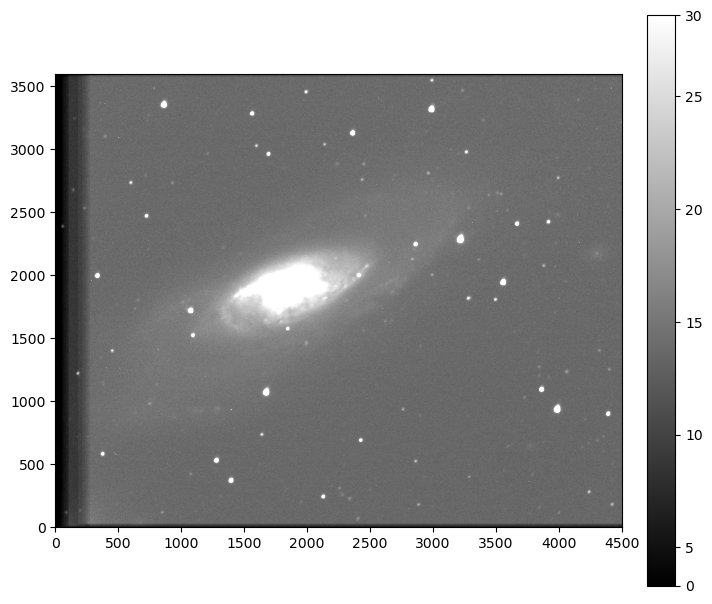

In [4]:
show_image(final_sc.data*2000, cmap="gray")

Segmentation map created in: 3.05134 s.
Background subtraction in: 3.02091 s.
Sérsic fitting in progress, this may take a while.
Sérsic fit found in: 976.048 s.

SINGLE COMPONENT SÉRSIC FIT
Sérsic index (n)=7.312
Ellipticity of the Sérsic fit=0.496
Half-light radius=6519
Chi-squared=1.097

Good morphological fit found.
Good Sérsic fit found.


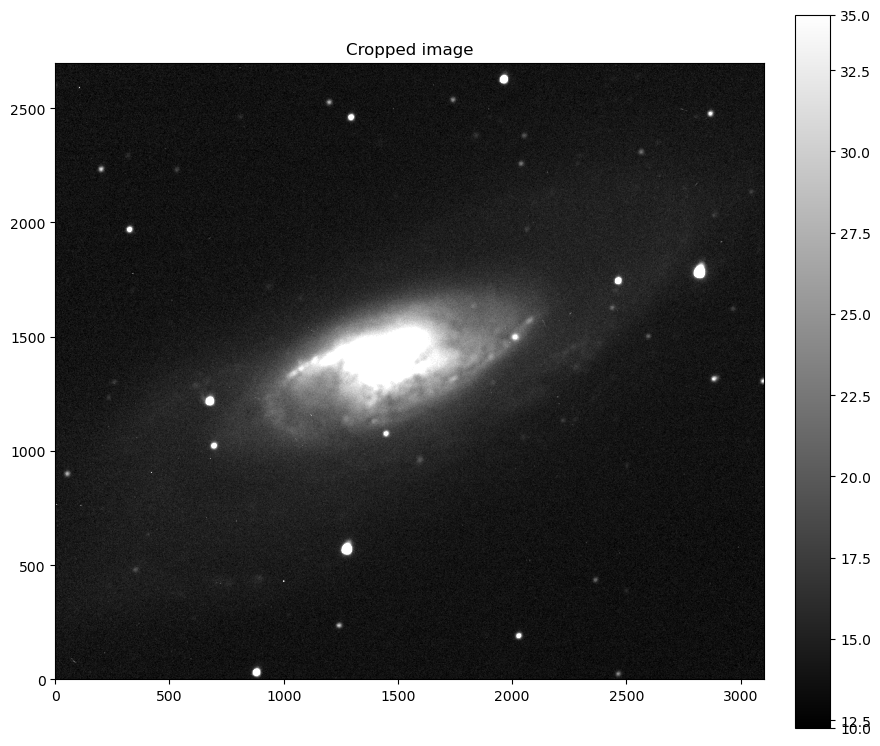

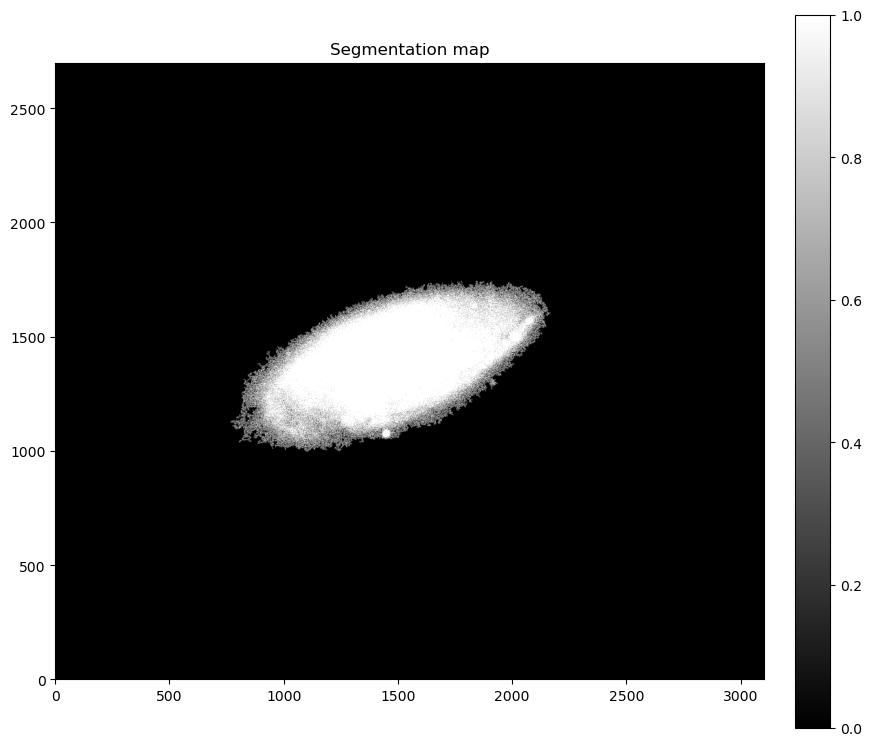

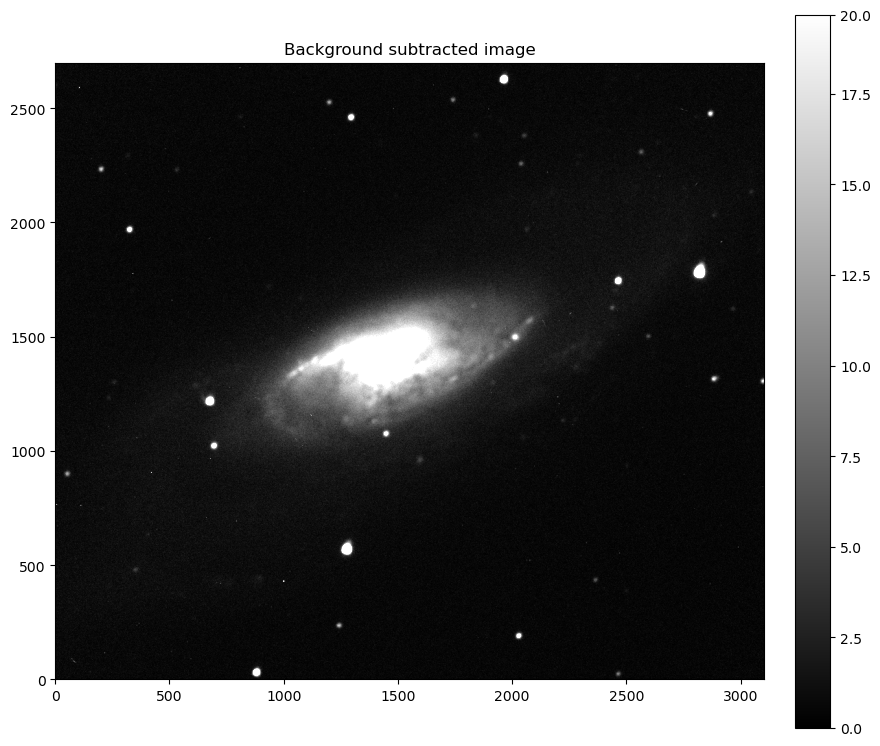

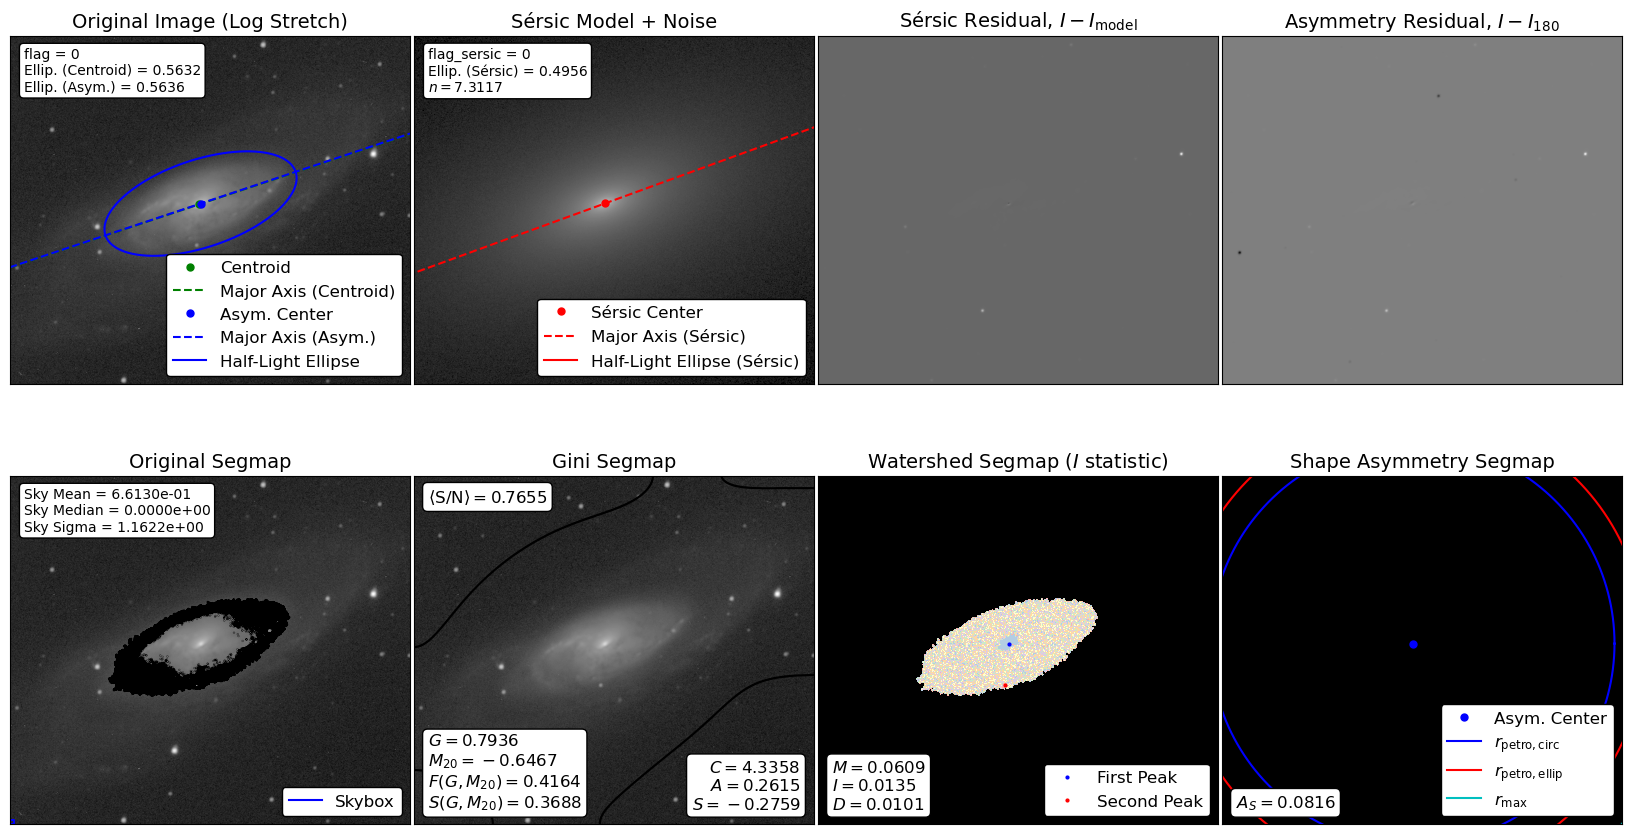

In [8]:
# Do Sérsic fitting
# Isophotes not yet implemented

fullfit, fitparam, fitres = fit(final_sc.data*2000, loc=np.array([[400, 3500], [500, 3200]]),
                                sersic=True, sersic2D=False, isophote=False, export=True,
                                show=np.array(["bgsub", "cutout", "segmap", "sersic", "sersic2D"]),
                                segmap_args={'thsig': 1.25, 'cpix':10000},
                                bgsub_args = {'SCsig':3.0, 'SCiter':10, 'thsig':2.0, 'ssize':10, 'statsig':3.0},
                                sersic_args = {'gain':1.0, 'Rratio':1.2,'maxiter':1000})

In [11]:
# Save the results of the fit to a text file

expath = dirnam + "/" + objnam
#save(fitres, "Sérsic fit for M106", typ="text", to=expath)

In [ ]:
tipps("fit")